# Task1: Symptom Prediction - Regression Problem

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import re
import random
from IPython.display import display
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib as mpl
%matplotlib inline
from sklearn.datasets import make_classification
from sklearn.utils import shuffle
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, RidgeClassifierCV, LassoCV
from sklearn.metrics import roc_auc_score, make_scorer, confusion_matrix, classification_report, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt 
from scipy import stats
from scipy.stats import norm, skew

# Import Data

In [2]:
train = pd.read_csv('pd_train.csv')
test = pd.read_csv('pd_test.csv')
train = train.drop('progression_rate', axis=1)

In [3]:
print(train.head())
print('**'* 50)
print(test.head())

   patno  time_from_diag        age  sex  domside  educlvl    heightcm  \
0      1        2.939524  52.296057    1        2        5  167.780072   
1      2        3.269823  80.902888    1        3        5  167.062085   
2      3        5.058708  81.153534    1        3        5  180.920299   
3      4        3.570508  73.899619    1        1        5  168.524877   
4      5        3.629288  53.851122    2        3        4  162.408731   

    weightkg  systolic_bp  diastolic_bp     hrstnd  rtremor  rigidity  \
0  55.617368   117.809229     79.478457  69.335387        1         1   
1  71.046884   117.107318     75.126492  81.997693        1         1   
2  71.565611   122.504921     77.380747  79.391687        0         1   
3  70.942746   121.141740     81.200441  74.485401        0         1   
4  48.834373   123.308461     76.871725  70.881446        1         1   

   bradykinesia  gait       moca  modseadl  mds_updrs  
0             1     0  26.838937        95          5  
1   

In [4]:
print(train.info())
print('**'* 50)
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 18 columns):
patno             1500 non-null int64
time_from_diag    1500 non-null float64
age               1500 non-null float64
sex               1500 non-null int64
domside           1500 non-null int64
educlvl           1500 non-null int64
heightcm          1500 non-null float64
weightkg          1500 non-null float64
systolic_bp       1500 non-null float64
diastolic_bp      1500 non-null float64
hrstnd            1500 non-null float64
rtremor           1500 non-null int64
rigidity          1500 non-null int64
bradykinesia      1500 non-null int64
gait              1500 non-null int64
moca              1500 non-null float64
modseadl          1500 non-null int64
mds_updrs         1500 non-null int64
dtypes: float64(8), int64(10)
memory usage: 211.1 KB
None
****************************************************************************************************
<class 'pandas.core.frame.DataFram

• patno: Patient identification number

• time_from_diag: Elapsed time from diagnosis, in years

• age: Age at diagnosis

• sex: Sex (1 = male, 2 = female)

• domside: Side predominantly affected at diagnosis (1 = right, 2 = left, 3 = symmetric)

• educlvl: Education level (1 = less than high school, 2 = high school, 3 = some college, 4 = undergraduate degree, 5 = graduate degree)

• heightcm: Height in centimeters at diagnosis

• weightkg: Weight in kilograms at diagnosis

• systolic_bp: Systolic blood pressure at diagnosis

• diastolic_bp: Diastolic blood pressure at diagnosis

• hrstnd: Standing heart rate at diagnosis

• rtremor: Resting tremor present at diagnosis

• rigidity: Rigidity present at diagnosis

• bradykinesia: Bradykinesia present at diagnosis

• gait: Gait disturbances present at diagnosis

• moca: Montreal Cognitive Assessment Score at diagnosis (lower scores indicate more severe symptoms)

• modseadl: Modified Schwab & England Activities of Daily Living Score at diagnosis (lower scores indicate more severe symptoms)

• mds_updrs: MDS-revised Unified Parkinson’s Disease Rating Scale (MDS-UPDRS) total score at time specified in time_from_diag (higher scores indicate more severe symptoms)

• progression_rate: Categorized rate of progression of Parkinson’s disease symptoms (1 = slow, 2 = moderate, 3 = fast, 4 = rapid)

# Data Visualization


 mu = 27.48 and sigma = 18.92



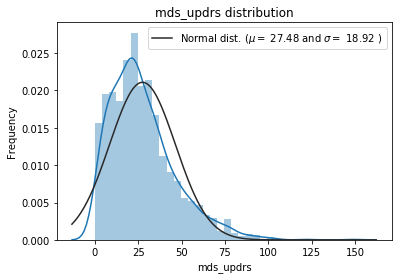

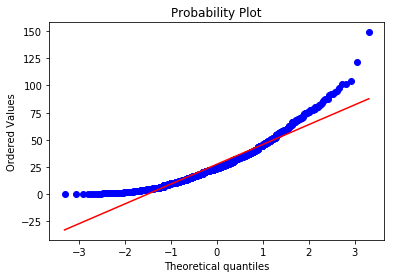

In [5]:
sns.distplot(train['mds_updrs'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['mds_updrs'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('mds_updrs distribution')

fig = plt.figure()
res = stats.probplot(train['mds_updrs'], plot=plt)
plt.show()

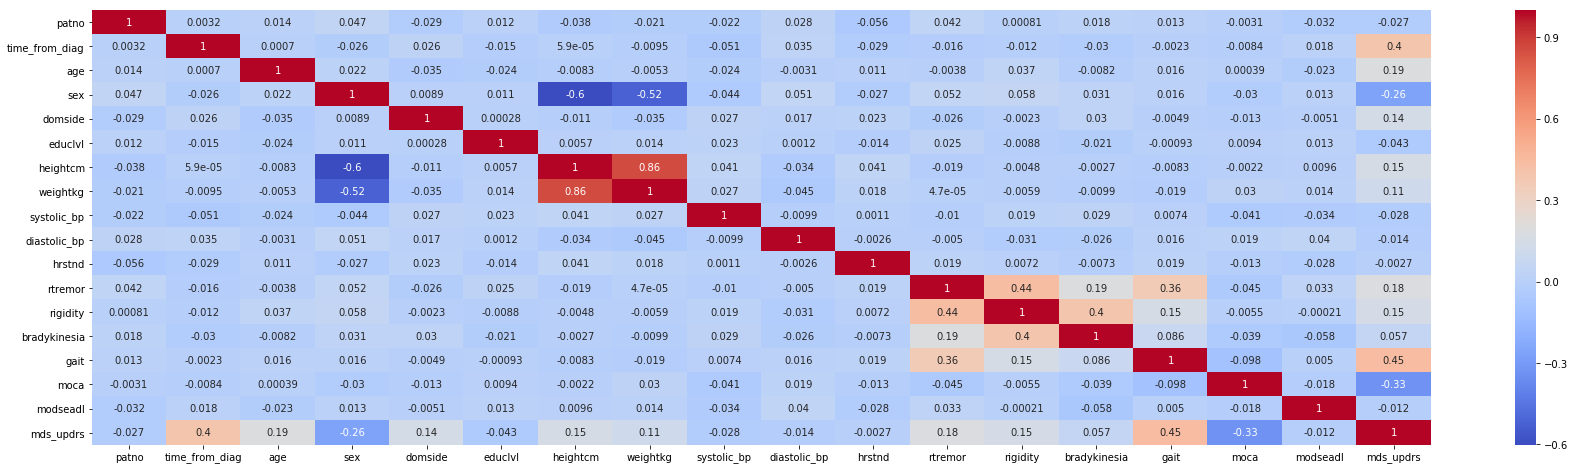

In [6]:
plt.figure(figsize=(30,8))
sns.heatmap(train.corr(),cmap='coolwarm',annot = True)
plt.show()

In [7]:
corr = train.corr()

In [8]:
corr[corr['mds_updrs']>0.3].index

Index(['time_from_diag', 'gait', 'mds_updrs'], dtype='object')

Because the size of feature is only 16 and we should try to leverage features as more as possible in this situation, so I will not remove any feature and select features in this dataset.

# Feature Engineering

In [9]:
#missing data
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(25)

,Total,Percent
mds_updrs,0,0.0
modseadl,0,0.0
time_from_diag,0,0.0
age,0,0.0
sex,0,0.0
domside,0,0.0
educlvl,0,0.0
heightcm,0,0.0
weightkg,0,0.0
systolic_bp,0,0.0


In [10]:
#missing data
total_test = test.isnull().sum().sort_values(ascending=False)
percent_test = (test.isnull().sum()/test.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_test, percent_test], axis=1, keys=['Total', 'Percent'])
missing_data.head(25)

,Total,Percent
modseadl,0,0.0
weightkg,0,0.0
time_from_diag,0,0.0
age,0,0.0
sex,0,0.0
domside,0,0.0
educlvl,0,0.0
heightcm,0,0.0
systolic_bp,0,0.0
moca,0,0.0


# Build Machine Learning Models

Train Test Split 

Now let's split the data into a training set and a testing set. We will train out model on the training set and then use the test set to evaluate the model.

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train.drop('mds_updrs', axis=1), train['mds_updrs'], test_size=0.3, random_state=101)

In [12]:
# we are going to scale to data
y_train= y_train.values.reshape(-1,1)
y_test= y_test.values.reshape(-1,1)
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.fit_transform(X_test)
y_train = sc_X.fit_transform(y_train)
y_test = sc_y.fit_transform(y_test)

In [13]:
X_train

array([[-0.06634091,  0.94747293, -1.59388628, ..., -0.34208373,
        -0.24439034, -0.95481123],
       [-0.57354215, -0.13380054,  1.51098418, ..., -0.34208373,
         0.83662776,  0.2855869 ],
       [-1.52309698, -0.74544534, -0.4248831 , ..., -0.34208373,
         0.62204509, -0.33461216],
       ...,
       [-0.36741927,  1.81903371, -0.30985739, ..., -0.34208373,
         1.04971191,  1.00915248],
       [ 1.39736313,  0.0731068 , -0.01842129, ..., -0.34208373,
         0.28199774,  0.38895342],
       [ 0.2440014 , -0.90072301,  0.10173095, ..., -0.34208373,
         0.79375201, -1.78174332]])

# Linear Regression

In [14]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()

In [15]:
lm.fit(X_train,y_train)
print(lm)

LinearRegression()


Model Evaluation 

Evaluate the model by checking out it's coefficients and how we can interpret them.

In [16]:
# print the intercept
print(lm.intercept_)

[2.08753522e-16]


In [17]:
print(lm.coef_)

[[-0.00446927  0.38370352  0.17697707 -0.29182633  0.13558918 -0.02186738
  -0.00371462 -0.00585849 -0.01911346 -0.02995077 -0.00261157  0.02345233
   0.10203277 -0.00452374  0.39934661 -0.27866025 -0.01517905]]


Predictions from our Model 

In [18]:
predictions = lm.predict(X_test)
predictions= predictions.reshape(-1,1)

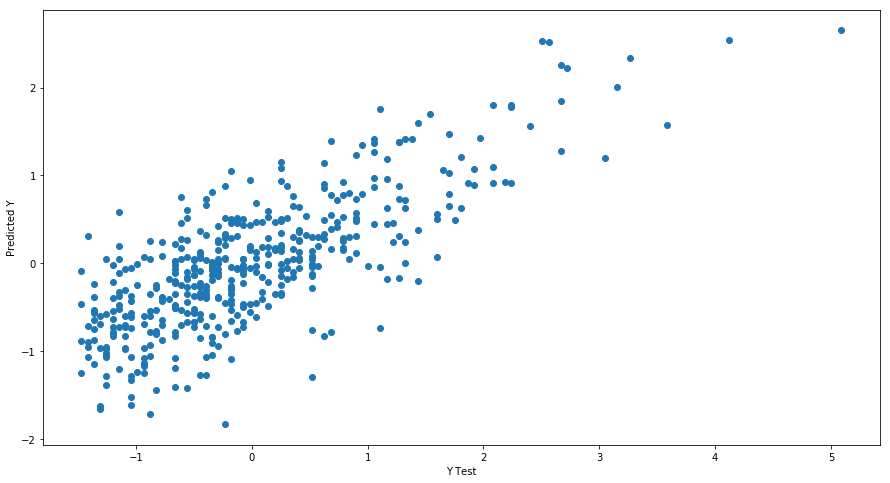

In [19]:
plt.figure(figsize=(15,8))
plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()

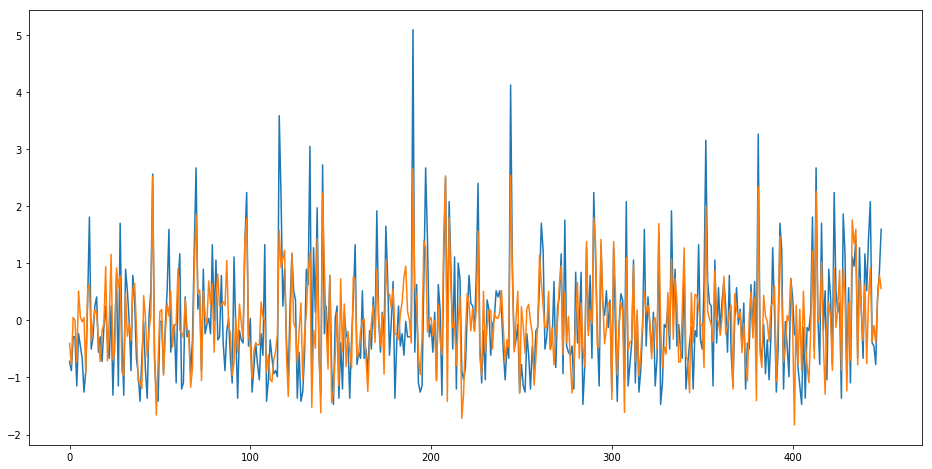

In [20]:
plt.figure(figsize=(16,8))
plt.plot(y_test,label ='Test')
plt.plot(predictions, label = 'predict')
plt.show()

Regression Evaluation Metrics

Mean Absolute Error (MAE) is the mean of the absolute value of the errors

Mean Squared Error (MSE) is the mean of the squared errors

Root Mean Squared Error (RMSE) is the square root of the mean of the squared errors

Comparing these metrics:

MAE is the easiest to understand, because it's the average error. 

MSE is more popular than MAE, because MSE "punishes" larger errors, which tends to be useful in the real world. 

RMSE is even more popular than MSE, because RMSE is interpretable in the "y" units. All of these are loss functions, because we want to minimize them.

In [21]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 0.49835345152656574
MSE: 0.4028717010398279
RMSE: 0.6347217508797283


# Gradient Boosting Regression

In [22]:
from sklearn import ensemble
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, r2_score

In [23]:
params = {'n_estimators': 100, 'max_depth': 4, 'min_samples_split': 2, 'learning_rate': 0.05, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)
clf.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GradientBoostingRegressor(learning_rate=0.05, max_depth=4)

In [24]:
clf_pred=clf.predict(X_test)
clf_pred= clf_pred.reshape(-1,1)

In [25]:
print('MAE:', metrics.mean_absolute_error(y_test, clf_pred))
print('MSE:', metrics.mean_squared_error(y_test, clf_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, clf_pred)))

MAE: 0.4189948801611396
MSE: 0.3052407179179532
RMSE: 0.5524859436383456


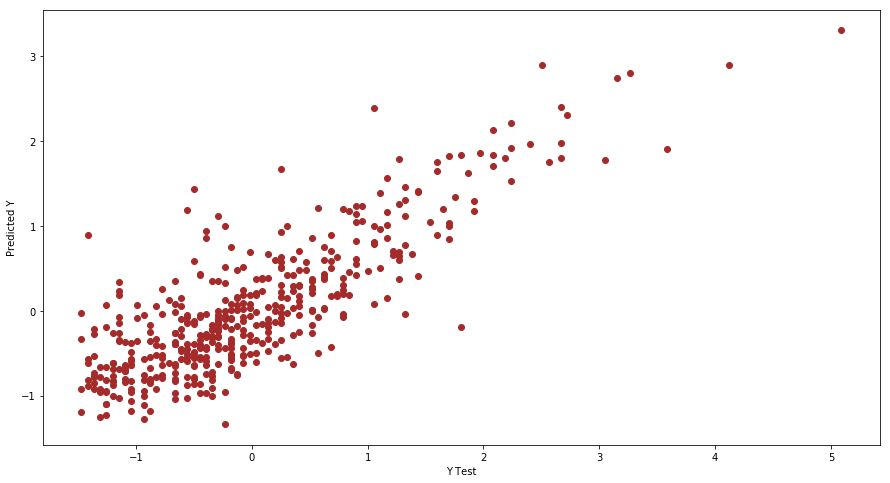

In [26]:
plt.figure(figsize=(15,8))
plt.scatter(y_test,clf_pred, c= 'brown')
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()

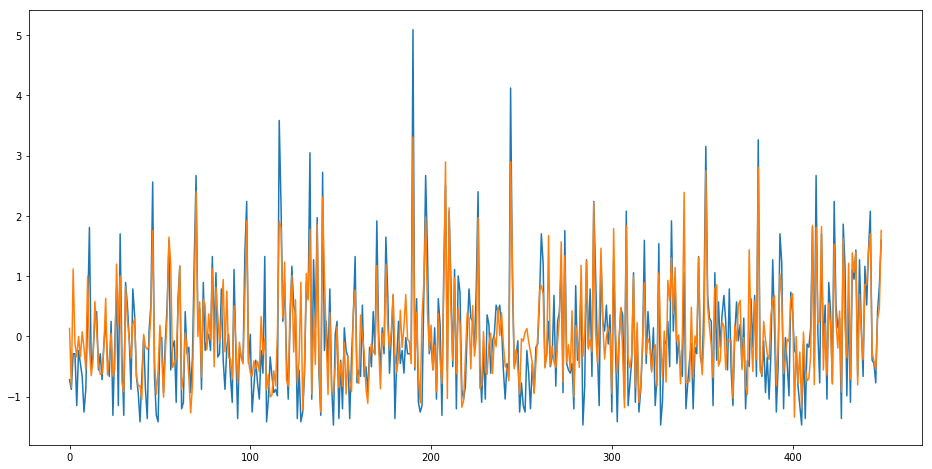

In [27]:
plt.figure(figsize=(16,8))
plt.plot(y_test,label ='Test')
plt.plot(clf_pred, label = 'predict')
plt.show()

# Decision Tree Regression

In [28]:
from sklearn.tree import DecisionTreeRegressor
dtreg = DecisionTreeRegressor(random_state = 100)
dtreg.fit(X_train, y_train)

DecisionTreeRegressor(random_state=100)

In [29]:
dtr_pred = dtreg.predict(X_test)
dtr_pred= dtr_pred.reshape(-1,1)

In [30]:
print('MAE:', metrics.mean_absolute_error(y_test, dtr_pred))
print('MSE:', metrics.mean_squared_error(y_test, dtr_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, dtr_pred)))

MAE: 0.5850092907484373
MSE: 0.6724351168980159
RMSE: 0.8200214124631234


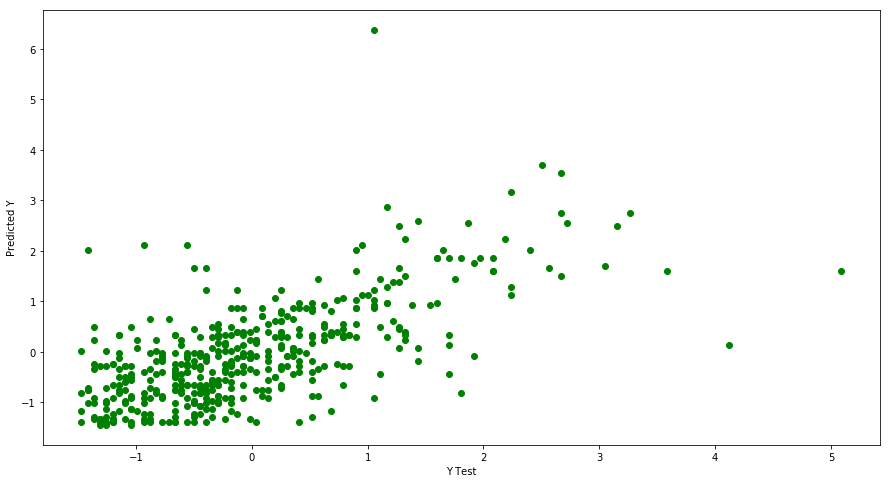

In [31]:
plt.figure(figsize=(15,8))
plt.scatter(y_test,dtr_pred,c='green')
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()

# Support Vector Machine Regression

In [32]:
from sklearn.svm import SVR
svr = SVR(kernel = 'rbf')
svr.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


SVR()

In [33]:
svr_pred = svr.predict(X_test)
svr_pred= svr_pred.reshape(-1,1)

In [34]:
print('MAE:', metrics.mean_absolute_error(y_test, svr_pred))
print('MSE:', metrics.mean_squared_error(y_test, svr_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, svr_pred)))

MAE: 0.47406586457715005
MSE: 0.37269412176817984
RMSE: 0.6104867908220291


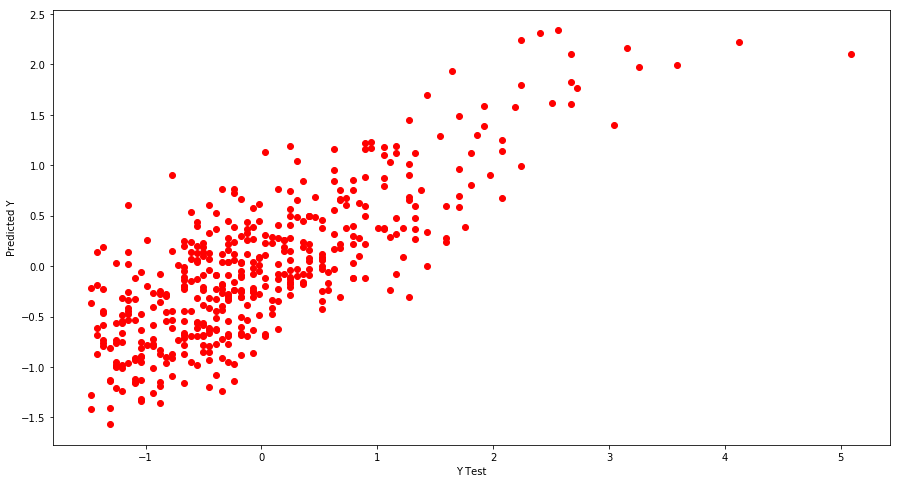

In [35]:
plt.figure(figsize=(15,8))
plt.scatter(y_test,svr_pred, c='red')
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()

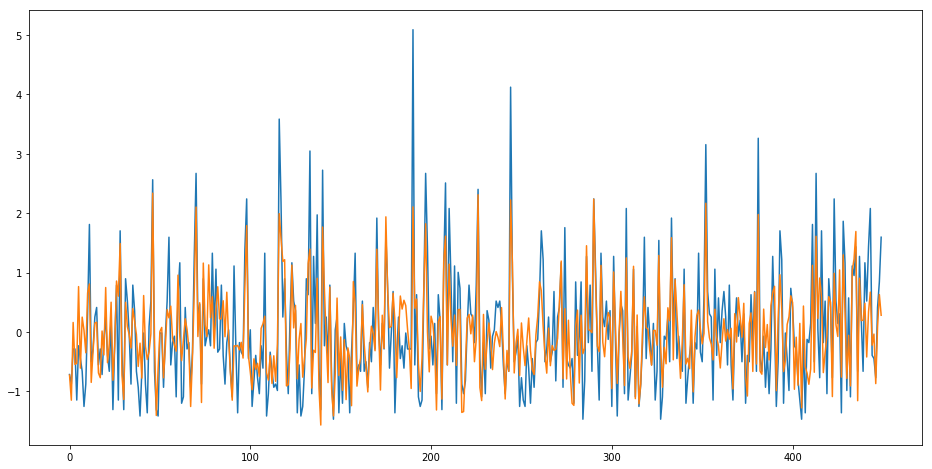

In [36]:
plt.figure(figsize=(16,8))
plt.plot(y_test,label ='Test')
plt.plot(svr_pred, label = 'predict')
plt.show()

# Random Forest Regression 

In [37]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators = 100, random_state = 0)
rfr.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestRegressor(random_state=0)

In [38]:
rfr_pred= rfr.predict(X_test)
rfr_pred = rfr_pred.reshape(-1,1)

In [39]:
print('MAE:', metrics.mean_absolute_error(y_test, rfr_pred))
print('MSE:', metrics.mean_squared_error(y_test, rfr_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, rfr_pred)))

MAE: 0.4420035926985434
MSE: 0.3560559267787656
RMSE: 0.5967042205136189


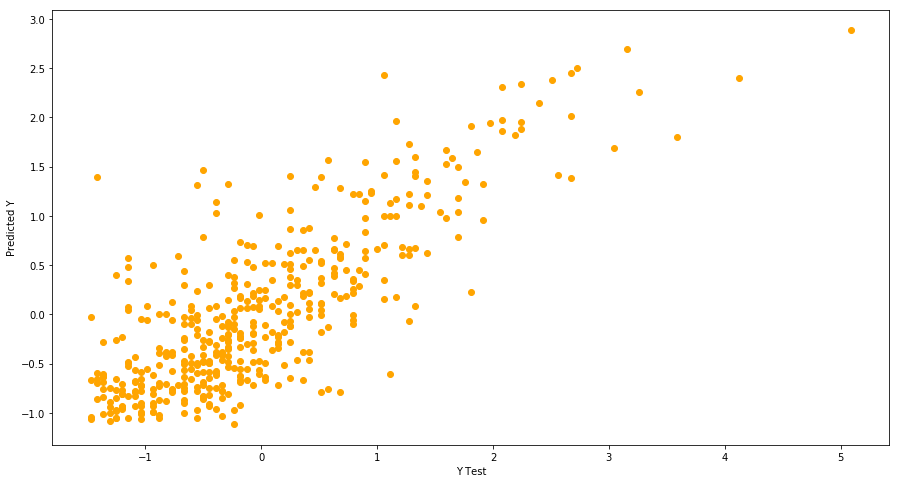

In [40]:
plt.figure(figsize=(15,8))
plt.scatter(y_test,rfr_pred, c='orange')
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()

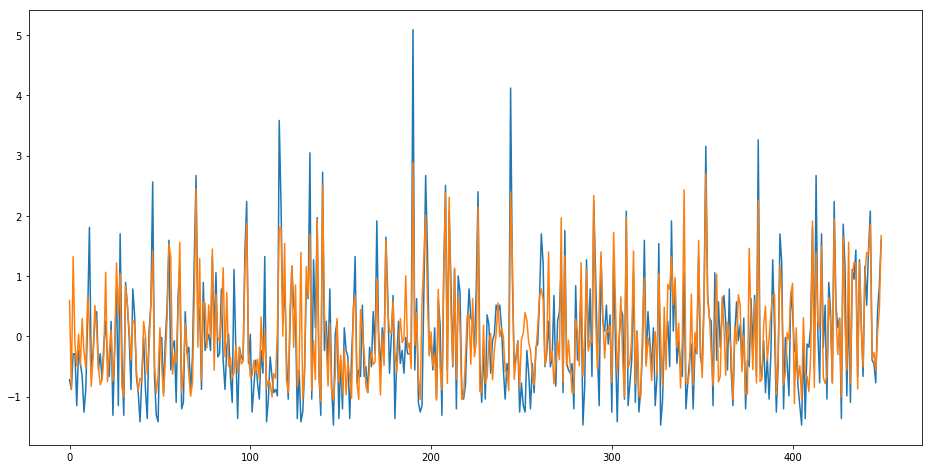

In [41]:
plt.figure(figsize=(16,8))
plt.plot(y_test,label ='Test')
plt.plot(rfr_pred, label = 'predict')
plt.show()

# Model Comparison
By comparing these three metrics below, we could know Xgboost performs best among these models.

In [42]:
error_rate=np.array([metrics.mean_squared_error(y_test, predictions),metrics.mean_squared_error(y_test, clf_pred),metrics.mean_squared_error(y_test, dtr_pred),metrics.mean_squared_error(y_test, svr_pred),metrics.mean_squared_error(y_test, rfr_pred)])

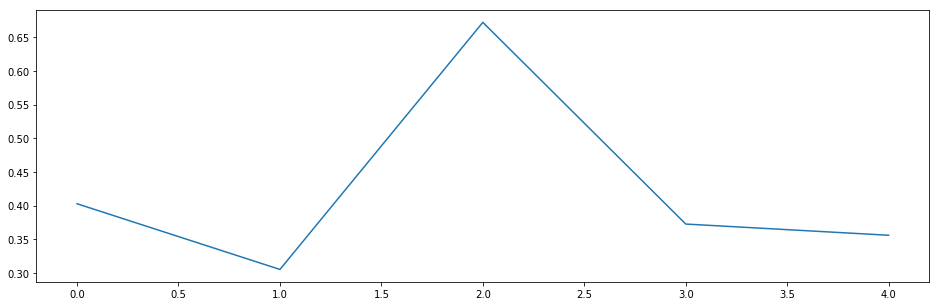

In [43]:
plt.figure(figsize=(16,5))
plt.plot(error_rate)

# Predict on Test Data 

In [44]:
a = pd.read_csv('pd_test.csv')

In [45]:
test_id = a['patno']
a = pd.DataFrame(test_id, columns=['patno'])

In [46]:
test = sc_X.fit_transform(test)

In [47]:
test.shape

(500, 17)

In [48]:
test_prediction_gbdt = clf.predict(test)
test_prediction_gbdt= test_prediction_gbdt.reshape(-1,1)

In [49]:
test_prediction_gbdt

array([[-6.90474462e-01],
       [-8.39477650e-02],
       [ 3.09471067e-01],
       [ 8.53975140e-01],
       [ 9.86248897e-01],
       [ 2.10701256e-01],
       [-2.49610134e-01],
       [-6.50727605e-01],
       [ 2.20382492e+00],
       [ 2.04915521e-01],
       [ 3.77944920e-01],
       [-6.32838831e-01],
       [ 6.95009401e-01],
       [-4.92391706e-01],
       [-6.99308419e-01],
       [-3.19294361e-01],
       [-6.13207468e-01],
       [-4.94850063e-01],
       [ 9.89871903e-01],
       [-1.69339077e-01],
       [-7.32995073e-01],
       [-5.84855995e-01],
       [ 2.30504424e-01],
       [-7.80230531e-01],
       [-4.31123302e-01],
       [-5.87029610e-01],
       [ 3.90410572e-01],
       [ 1.87371780e-01],
       [-4.14847175e-01],
       [-4.11661192e-01],
       [ 3.15467970e-01],
       [ 1.46233191e+00],
       [-1.11047002e+00],
       [-8.12132736e-01],
       [ 7.68301995e-02],
       [-1.27112552e-01],
       [-6.47598837e-01],
       [-3.14276851e-01],
       [-1.2

In [50]:
test_prediction_gbdt =sc_y.inverse_transform(test_prediction_gbdt)

In [51]:
test_prediction_gbdt = pd.DataFrame(test_prediction_gbdt, columns=['mds_updrs'])

In [52]:
test_prediction_gbdt.head()

,mds_updrs
0,14.507558
1,25.785690
2,33.101163
3,43.226008
4,45.685588


In [53]:
result = pd.concat([a,test_prediction_gbdt], axis=1)

In [54]:
result.head()

,patno,mds_updrs
0,1501,14.507558
1,1502,25.785690
2,1503,33.101163
3,1504,43.226008
4,1505,45.685588


In [55]:
result.to_csv('SymptomPrediction.csv',index=False)